In [109]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sqlite3 as sql
import math
import scipy.optimize as optimize
from scipy.stats import beta

from functools import reduce

a4_dims = (11.7, 8.27)

In [8]:
def fetch_axes(db_conn, query, *args):
    return list(zip(*db_conn.cursor().execute(query,args)))

# Distribution of $\frac{h}{h_{max}}$ of failed and succeeded search runs.

In [9]:
query_failed = """
SELECT entropy
FROM search_run
WHERE last_unsat > 0
"""

query_succeeded = """
SELECT entropy
FROM search_run
WHERE last_unsat = 0
"""

bins = np.arange(0.6,1.0,0.0025)

def get_entropy_dist(file):
    with sql.connect(file) as conn:
        failures, = fetch_axes(conn, query_failed)
        successes, = fetch_axes(conn, query_succeeded)
        return failures, successes
    
def plot_dist(failures, successes):
    fix, ax = plt.subplots(figsize=a4_dims)
    sns.distplot(failures, ax = ax, label='failed runs', axlabel='Entropy', bins=bins);
    sns.distplot(successes, ax = ax, label='succeeded runs', axlabel='Entropy', bins=bins);
    ax.legend();
    ax.grid();
    return ax
    
def plot_entropy_dist(file):
    fs, ss = get_entropy_dist(file)
    return plot_dist(fs, ss)

## Concerning $k = 3$, $v = 500$, $r = 4.1$

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


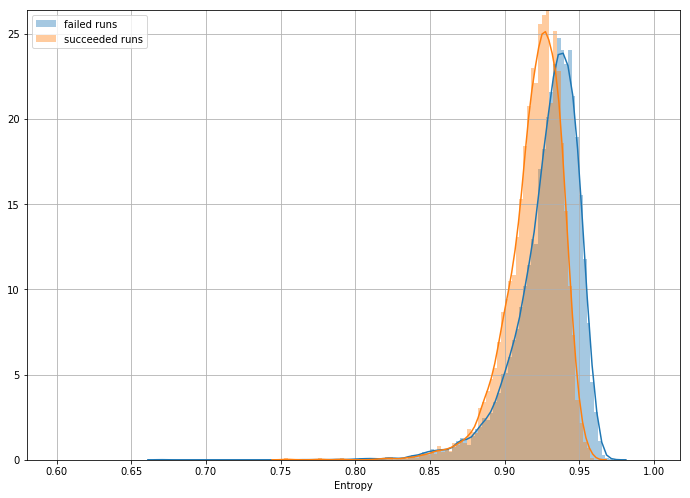

In [10]:
plot_entropy_dist('data/k3-v500-r4.1.raw.db');

## Concerning $k = 3$, $v = 500$, $r = 4.2$

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


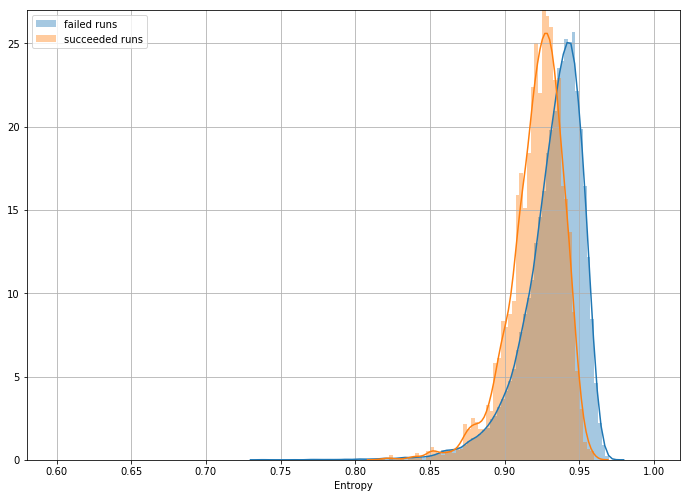

In [11]:
plot_entropy_dist('data/k3-v500-r4.2.raw.db');

# Entropy Analysis

## Tools

### Measurement
The following functions measure the similarity of the sample distribution with an assumed distribution.

- Squared Error, which needs to be minimized $e(f, x, y) = \sum_{i} (f(x_i) - y_i)^2$
- Likelihood, which needs to be maximized $l(f, x) = \sum_{i} log(f(x_i))$

In [12]:
def squared_error(f, data):
    ys, xs = np.histogram(data, bins)
    xs = xs[:-1]
    squared_errors = np.vectorize(lambda y1, y2: pow(y1-y2, 2))
    f1 = np.vectorize(f)
    return sum(squared_errors(f1(xs),ys))

def log_likelihood(pdf, data):
    def safe_log(x):
        if x == 0:
            return 0
        else:
            return math.log(x)
    f = np.vectorize(lambda x: safe_log(pdf(x)))
    return sum(f(data))

### Probability Distributions
The following functions describe probabilty distributions with their parameters
- Beta Distribution
- Normal Distribution

In [13]:
def beta_pdf(vec):
    p, q = vec
    def B(p,q):
        return math.gamma(p) * math.gamma(q) / math.gamma(p + q)
    return lambda x: x ** (p - 1) * (1 - x) ** (q - 1) / B(p,q)

def normal_pdf(vec):
    mu, sigma_square = vec
    return lambda x: (1/math.sqrt(2*math.pi*sigma_square))*math.exp(-((x-mu)**2)/(2*sigma_square)) 

### Gradient Descent
The definition of a gradient descent algorithm to find a parameter vector giving the minimal function output.

**NOTE**: *replacement by something predefined in a library would be nice*

In [20]:
def partial_difference_quotient(f, i, vs, dx = 0.00001):
    vs1 = np.array([v_j + (dx if j == i else 0) for j, v_j in enumerate(vs)])
    return (f(vs1) - f(vs))/dx

def estimate_gradient(f, vs, dx=0.00001):
    f1 = np.vectorize(lambda i: partial_difference_quotient(f, i, vs, dx))
    idxs = np.arange(0,len(vs),dtype=int)
    return f1(idxs)

def step(vs, directions, step_size):
    return np.vectorize(lambda v, d: v + step_size * d)(vs, directions)

def negate(f):
    return lambda *args, **kwargs: -f(*args, **kwargs)

## Find a Distribution

In [27]:
def evaluate_distribution(file,
                          metric,
                          pdf,
                          init_vector,
                          bins,
                          labels = None,
                          **kwargs):
    
    
    
    def eval_set(data, label, ax):
        metric_set = lambda vec: metric(pdf(vec), data)
        
        
        result = optimize.minimize(
            metric_set,
            init_vector,
            **kwargs
        )
        theta = result.x
        print(theta)
        
        if labels:
            print(
                label, 
                reduce(
                    lambda l,r: l+" "+r,
                    map(
                        lambda p: "{}: {}".format(*p),
                        zip(labels, theta)),
                    ""))
        else:
            print(label, theta)
            
        ax.plot(bins, np.vectorize(pdf(theta))(bins))
        
    a = plot_entropy_dist(file);
    fs, ss = get_entropy_dist(file)
    eval_set(fs, "Failures:", a)
    eval_set(ss, "Successes:", a)

### Beta Distribution

#### Maximize Likelihood

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[153.24554177  11.79667418]
Failures:  a: 153.2455417665504 b: 11.796674177025992
[217.63925028  18.91281756]
Successes:  a: 217.63925027770415 b: 18.91281756392455


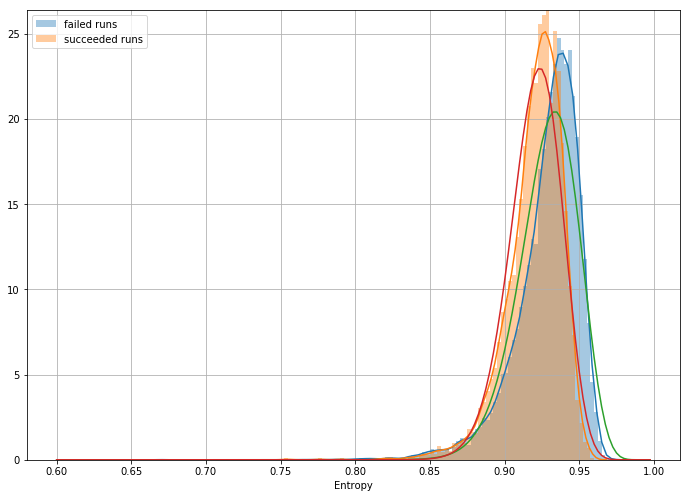

In [110]:
def pdf(vec):
    return lambda x: beta.pdf(x, *vec)

evaluate_distribution(
    'data/k3-v500-r4.1.raw.db',
    negate(log_likelihood),
    #squared_error,
    pdf,
    np.random.uniform(0,1,2),
    bins,
    ["a", "b"],
    tol = 0.0001,
    bounds = [(0.001,None),(0.001,None),],
)

## Normal Distribution

# Concerning $k = 3$, $v = 500$, $r = 4.1$ with early restarts

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


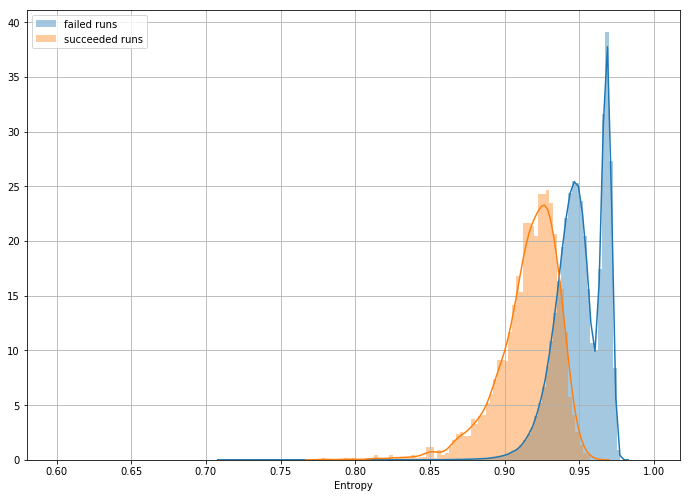

In [74]:
plot_entropy_dist('data/k3-v500-r4.1-er.raw.db');

# Concerning $k = 3$, $v = 500$, $r = 4.2$ with early restarts

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


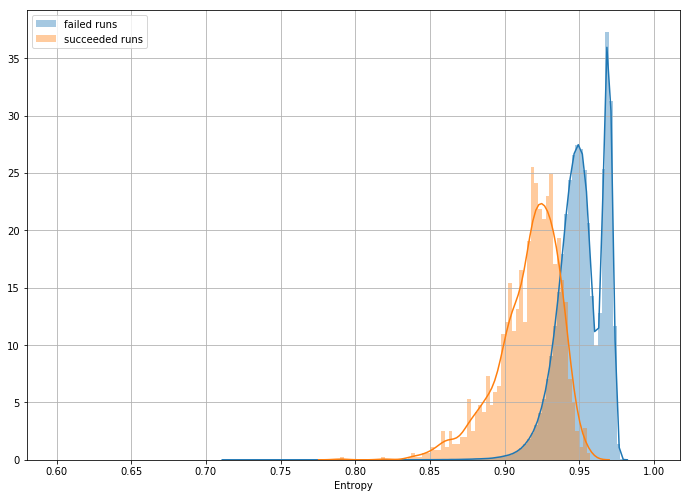

In [75]:
plot_entropy_dist('data/k3-v500-r4.2-er.raw.db');